# Spam Email Classification

- Goal: Build classification to detect whether an email is spam or not
- Data source: <http://archive.ics.uci.edu/ml/datasets/Spambase>
- Model: Support Vector Classifier/ XGBoost/ LightGBM/ Deep Neural Network/ Decision Tree/ Logistic Regression

### In this project we consider two scenarios:
1. What is the best model **in terms of the overall predictive accuracy** and what's the best hyperparameter of that model?
2. What is the best model **in terms of the cost sensitive condition** and what's the best hyperparameter of that model?

### Process

- EDA
- Data Preprocessing
- Modeling 
  - **Nested CV:** Find the best model
  - **Hyperparameter tuning:** Find the best parameter
  - **DNN Tuning:** Kera tuner for DNN tuning
- Conclusion

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import scikitplot as skplt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix, \
                            plot_confusion_matrix, classification_report, make_scorer, accuracy_score

import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
from tensorflow import keras
from keras_tuner import RandomSearch
import warnings
warnings.filterwarnings("ignore")

In [85]:
columns=['wf_make','wf_address','wf_all','wf_3d','wf_our','wf_over','wf_remove','wf_internet','wf_order','wf_mail',
      'wf_receive','wf_will','wf_people','wf_report','wf_addresses','wf_free','wf_business','wf_email','wf_you',
      'wf_credit','wf_your','wf_font','wf_000','wf_money','wf_hp','wf_hpl','wf_george','wf_650','wf_lab','wf_labs',
     'wf_telnet','wf_857','wf_data','wf_415','wf_85','wf_technology','wf_1999','wf_parts','wf_pm','wf_direct',
      'wf_cs','wf_meeting','wf_original','wf_project','wf_re','wf_edu','wf_table','wf_conference','wf_1','wf_2',
     'wf_3','wf_4','wf_5','wf_6','crl_average','crl_longest','crl_total','target']

df = pd.read_csv('spambase.data', names = columns)
df.head(3)


,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,wf_receive,wf_will,wf_people,wf_report,wf_addresses,wf_free,wf_business,wf_email,wf_you,wf_credit,wf_your,wf_font,wf_000,wf_money,wf_hp,wf_hpl,wf_george,wf_650,wf_lab,wf_labs,wf_telnet,wf_857,wf_data,wf_415,wf_85,wf_technology,wf_1999,wf_parts,wf_pm,wf_direct,wf_cs,wf_meeting,wf_original,wf_project,wf_re,wf_edu,wf_table,wf_conference,wf_1,wf_2,wf_3,wf_4,wf_5,wf_6,crl_average,crl_longest,crl_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1


## EDA

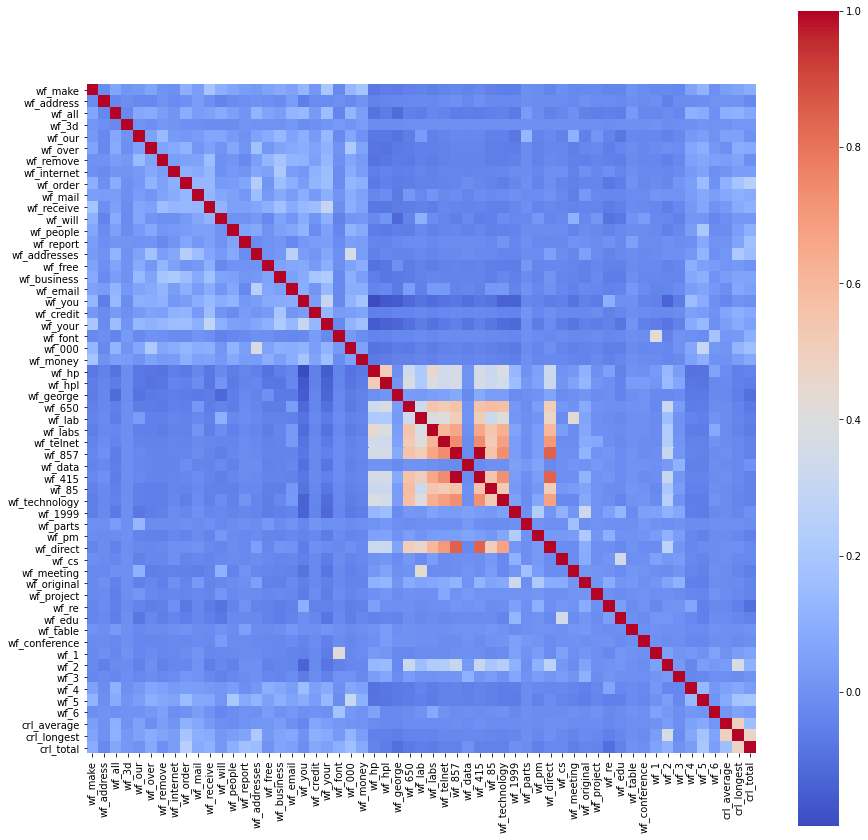

In [180]:
# Present feature correlation with heatmap

df_corr = df.iloc[:, :-1].corr()
plt.subplots(figsize=(15, 15))
sns.heatmap(df_corr, cmap = 'coolwarm', square = True)
plt.show()


In [173]:
# Show the proportion of spam mail
perc = round((df['target'].value_counts()/df.shape[0])*100, 2)
print(f'Spam Email Proportion: {perc[1]}')
print(f'Non-Spam Email Proportion: {perc[0]}')      
      

Spam Email Proportion: 39.4
Non-Spam Email Proportion: 60.6


In [29]:
df.describe()

,wf_make,wf_address,wf_all,wf_3d,wf_our,wf_over,wf_remove,wf_internet,wf_order,wf_mail,wf_receive,wf_will,wf_people,wf_report,wf_addresses,wf_free,wf_business,wf_email,wf_you,wf_credit,wf_your,wf_font,wf_000,wf_money,wf_hp,wf_hpl,wf_george,wf_650,wf_lab,wf_labs,wf_telnet,wf_857,wf_data,wf_415,wf_85,wf_technology,wf_1999,wf_parts,wf_pm,wf_direct,wf_cs,wf_meeting,wf_original,wf_project,wf_re,wf_edu,wf_table,wf_conference,wf_;,wf_(,wf_[,wf_!,wf_$,wf_#,crl_average,crl_longest,crl_total,target
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,0.059824,0.541702,0.093930,0.058626,0.049205,0.248848,0.142586,0.184745,1.662100,0.085577,0.809761,0.121202,0.101645,0.094269,0.549504,0.265384,0.767305,0.124845,0.098915,0.102852,0.064753,0.047048,0.097229,0.047835,0.105412,0.097477,0.136953,0.013201,0.078629,0.064834,0.043667,0.132339,0.046099,0.079196,0.301224,0.179824,0.005444,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,0.201545,0.861698,0.301036,0.335184,0.258843,0.825792,0.444055,0.531122,1.775481,0.509767,1.200810,1.025756,0.350286,0.442636,1.671349,0.886955,3.367292,0.538576,0.593327,0.456682,0.403393,0.328559,0.555907,0.329445,0.532260,0.402623,0.423451,0.220651,0.434672,0.349916,0.361205,0.766819,0.223812,0.621976,1.011687,0.911119,0.076274,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.800000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000

## Train Test Split

In [ ]:
# Train-Test Split
X = df.drop(["target"], axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define cross-validation set
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


## Feature Engineering

In [198]:
def NestedCV(param_grid, names, models, normalize, cv=inner_cv, scoring='f1_micro'):
    cv_score = {}
    scaler = ColumnTransformer(
                transformers=[('ss', StandardScaler(), ['crl_average','crl_longest','crl_total'])],
                remainder="passthrough")
        
        
    for name, model, norm, param in zip(names, models, normalize, param_grid):
        print(name)
        normalization = norm
        if normalization:
            pipe = Pipeline([('scaler', scaler), ('estimator', model)])   
        else:
            pipe = Pipeline([('estimator', model)]) 
            
        clf = GridSearchCV(estimator=pipe, param_grid=param, n_jobs=-1, cv=cv, scoring=scoring, error_score = 'raise')
        score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
        cv_score[name] = score.mean()
    return cv_score
    

#Lift
# skplt.metrics.plot_lift_curve(y_test, predicted_probas_svm)
# plt.show()




## Modeling : NestedCV

#### Create parameter grid for all the hyperparameters

In [120]:
# KNN hyperparamter
k = list(range(2,15))
knn_paramGrid = dict(estimator__n_neighbors = k)

# Logistic Regression hyperparamter
c_values = [10**i for i in list(range(-5, 6))]
multiclass = ['multinomial','ovr']
lr_paramGrid = dict(estimator__C = c_values, estimator__multi_class = multiclass)

# Decition Tree hyperparamter
depth = list(range(1,25))
weight_options = ["entropy", "gini"]
dt_paramGrid = dict(estimator__max_depth = depth, estimator__criterion = weight_options)

# SVM hyperparamter
svc_paramGrid = [{'estimator__kernel': ['rbf'], 'estimator__gamma': [1e-3, 1e-4], 'estimator__C': [1, 10, 100, 1000]}]

# XGB hyperparameter
xgb_paramGrid = {'estimator__objective':['binary:logistic'], 'estimator__learning_rate': [1e-2, 1e-3],
                  'estimator__max_depth': [3,7,11], 'estimator__gamma':[0.01, 0.1],
                  'estimator__n_estimators':[300, 500], 'estimator__colsample_bytree':[0.3, 0.7]}

# LGBM hyperparameter
lgbm_paramGrid = {'estimator__objective':['binary'], 'estimator__learning_rate': [1e-2, 1e-3],
                   'estimator__max_depth': [3,7,11], 'estimator__n_estimators':[300, 500],
                   'estimator__colsample_bytree':[0.3, 0.7]}

# NestedCV param grid
models_param_grid = [lr_paramGrid, lgbm_paramGrid, xgb_paramGrid, svc_paramGrid, dt_paramGrid, knn_paramGrid]

# # Neural Network
# activations = ['relu', 'tanh']
# optimizers = ['adam']
# hiddens = [64, 128, 256]
# epochs = list(range(3, 10))
# nn_paramGrid = dict(activation=activations, 
#                      optimizer=optimizers, 
#                      hidden=hiddens, 
#                      epochs = epochs)

# # Ensemble method hyperparameter
# stack_paramGrid = {'regrtree__max_depth': depth}


In [107]:
# Define model: Logistic Regression/ Decision Tree/ K-NN/ Support Vector Classifier/ LightGBM/ XGBoost
# Perform Nested Cross Validation to find the best model
models = [LogisticRegression(solver ='newton-cg'), 
         LGBMClassifier(verbosity = 0, class_weight=None), 
         XGBClassifier(verbosity = 0, class_weight=None), 
         SVC(probability=True), 
         DecisionTreeClassifier(), 
         KNeighborsClassifier()]
names = ['LR', 'LGBM','XGB','SVC','DT','KNN']
norm = [True, False, False, True, False, True]
NestedCV(param_grid= models_param_grid, models = models, names = names, normalize = norm)

LR
LGBM
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Wa

{'LR': 0.9274087711844403,
 'LGBM': 0.9534867582495398,
 'XGB': 0.953270547136855,
 'SVC': 0.9371861870367747,
 'DT': 0.925449653023651,
 'KNN': 0.9143671812302319}

As the result of Nested cross validation showing above, XGBoost is the best model, therefore we continue to search for the best parameter of XGBoost

## XGBoost Hyperparameter Tunning with GridSearchCV

In [189]:
# Find the best parameter 
xgb = XGBClassifier(verbosity = 0, class_weight=None)
clf = GridSearchCV(estimator=xgb, param_grid=lgbm_paramGrid, n_jobs=-1, cv=inner_cv, scoring='f1_micro', error_score = 'raise')
grid_result = clf.fit(X_train, y_train)

print(f"Best score of gridsearch is {grid_result.best_score_}\n") 
print(f"The best hyperparameter of XGBoost is  {grid_result.best_params_}\n")

# lgb = LGBMClassifier(**params)
# lgb.fit(X_train.values, y_train)
# y_train_xgb = xgb_clf.predict(X_train.values)
# y_pred_gb = xgb_clf.predict(X_test.values)


Best score of gridsearch is 0.9426642168039839

The best hyperparameter of XGBoost is  {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 300, 'estimator__objective': 'binary'}



Training set score: 0.9573369565217391
Testing set score: 0.9467969598262758 

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.95       531
         1.0       0.96      0.91      0.94       390

    accuracy                           0.95       921
   macro avg       0.95      0.94      0.95       921
weighted avg       0.95      0.95      0.95       921



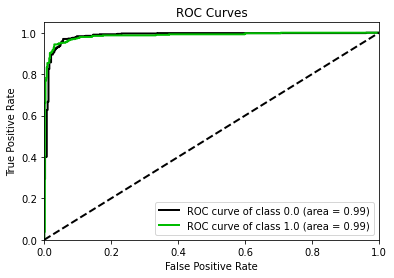

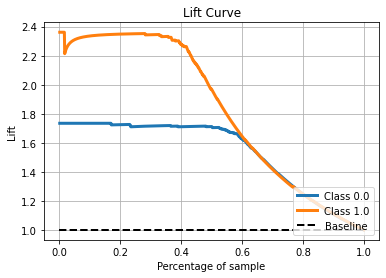

In [188]:
best_param = {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.01, \
              'estimator__max_depth': 3, 'estimator__n_estimators': 300, 'estimator__objective': 'binary'}
xgb_clf = XGBClassifier(**best_param, verbosity = 0, class_weight=None)
xgb_clf.fit(X_train, y_train)
y_train_xgb = xgb_clf.predict(X_train)
y_pred_xgb = xgb_clf.predict(X_test)

print('Training set score:', accuracy_score(y_train, y_train_xgb))
print('Testing set score:', accuracy_score(y_test, y_pred_xgb),'\n')

# Showing the classificatino report
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC Curve
y_pred_proba = xgb_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba, plot_micro = False, plot_macro = False)
    
# Plot the Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_pred_proba)
plt.show()

As the result shown above, the accuracy is 95.7% in the train set and 94.6% in test set.

## Hyperparameter with Neural Network using Kera-tuner
In addition to the above classification models, we want to check he performance of Neural Network as well

In [190]:
# Create function for Neural Network constructure

def build_model(hp):  #hp means hyper parameters
    """
    Reference: https://www.analyticsvidhya.com/blog/2021/08/easy-hyperparameter-tuning-in-neural-networks-using-keras-tuner/
    """
    model=Sequential()
    model.add(Flatten(input_dim=X_train.shape[1]))
    #providing the range for hidden layers  
    for i in range(hp.Int('num_of_layers',2,20)):         
        #providing range for number of neurons in hidden layers
        model.add(Dense(units=hp.Int('num_of_neurons'+ str(i),min_value=32,max_value=512,step=32),
                                    activation='relu'))
    model.add(Dense(1,activation='sigmoid'))    #output layer
    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),   #tuning learning rate
                  loss='binary_crossentropy',metrics=['accuracy'])
    return model


In [191]:
# Transform the data into float data type
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

In [192]:
tuner=RandomSearch(build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    overwrite=True)

In [193]:
#tells us how many hyperparameters we are tuning
#in our case it's 3 =layers,neurons,learning rate
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
num_of_neurons0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_of_neurons1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [194]:
#fitting the tuner
tuner.search(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Trial 5 Complete [00h 00m 07s]
val_accuracy: 0.9218240976333618

Best val_accuracy So Far: 0.9218240976333618
Total elapsed time: 00h 01m 29s
INFO:tensorflow:Oracle triggered exit


The accuracy of Neural Network is 92.1%, which is lower than XGBoost model we just built
Based on the result, we can conclude that XGBoost is the best model in terms of the overall predictive accuracy

## Business Perspective: What is the best model under the cost sensitive scenario?
### Cost Sensitive Model : FInd the best model with nested cross validation

In [195]:
# We define a customized cost function by using 10:1 cost ratio for different misclassification errors.
def loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cost = cm[0][1] * 10 + cm[1][0] * 1
    return cost

scoring1 = make_scorer(loss_func, greater_is_better= False)

In [200]:
# Conducted nested cross vaidation with our customized scoreing function
NestedCV(param_grid= models_param_grid, models = models, names = names, normalize = norm, scoring = scoring1)

LR
LGBM
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Wa

{'LR': -311.4,
 'LGBM': -152.0,
 'XGB': -178.0,
 'SVC': -298.0,
 'DT': -268.6,
 'KNN': -279.2}

As the result of Nested cross validation showing above, LightGBM is the best model, therefore we continue to search for the best parameter of LigthGBM

### Cost Sensitive Model : Hyperparameter Tunning with GridSearchCV

In [202]:
# Find the best parameter of 
lgbm = LGBMClassifier(verbosity = 0, class_weight=None)
clf = GridSearchCV(estimator=lgbm, param_grid=lgbm_paramGrid, n_jobs=-1, cv=inner_cv, scoring='f1_micro', error_score = 'raise')
grid_result = clf.fit(X_train, y_train)


print(f"Best score of gridsearch is {grid_result.best_score_}\n") 
print(f"The best hyperparameter of LightGBM is  {grid_result.best_params_}\n")


[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__objective
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__objective
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Best score of gridsearch is 0.9502726181311997

The best hyperparameter of LightGBM is  {'estimator__colsample_bytree': 0.3, 'estimat

[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__objective
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Unknown parameter: estimator__learning_rate
[LightGBM] [Warning] Unknown parameter: estimator__colsample_bytree
[LightGBM] [Warning] Unknown parameter: estimator__objective
[LightGBM] [Warning] Unknown parameter: estimator__max_depth
[LightGBM] [Warning] Unknown parameter: estimator__n_estimators
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training set score: 0.998641304347826
Testing set score: 0.9663409337676439 

              precision    recall  f1-score   support



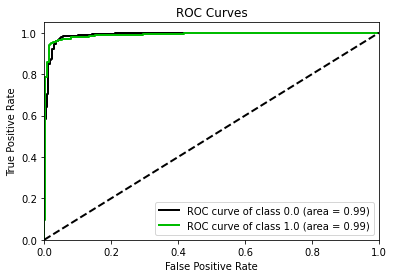

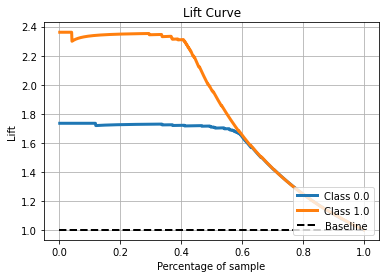

In [203]:
best_param = {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.01, \
              'estimator__max_depth': 3, 'estimator__n_estimators': 300, 'estimator__objective': 'binary'}
lgb_clf = LGBMClassifier(**best_param, verbosity = 0, class_weight=None)
lgb_clf.fit(X_train, y_train)
y_train_lgb = lgb_clf.predict(X_train)
y_pred_lgb = lgb_clf.predict(X_test)

print('Training set score:', accuracy_score(y_train, y_train_lgb))
print('Testing set score:', accuracy_score(y_test, y_pred_lgb),'\n')

# Showing the classificatino report
print(classification_report(y_test, y_pred_xgb))

# Plot the ROC Curve
y_pred_proba = lgb_clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba, plot_micro = False, plot_macro = False)
    
# Plot the Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_pred_proba)
plt.show()

## Conclusion

### In this project we consider two scenarios:
1. What is the best model **in terms of the overall predictive accuracy** and what's the best hyperparameter of that model?
2. What is the best model **in terms of the cost sensitive condition** and what's the best hyperparameter of that model?

### The results I found are demonstrated below:

- For the first scenario, I first used Nested CV to find the best model among several classification models, such as **Decision Tree/ Logistic Regression/ LightGBM/ XGBoost/ Support Vector Classifier.** The result shows that XGBoost has the best performance. Therefore I conducted hyperparameter tuning to find the best parameter of XGBoost, the best parameter is {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 300, 'estimator__objective': 'binary'}. The accuracy of this model is 95.7% on training set and 94.6% on testing set. **I also built deep neural network and use kera-tuner to find the best number of layers, nodes and learning rate, and the accuracy of DNN model after tuning is 92.18%.** To sum up, I conclude that **XGBoost is the best model we found under the first scenario.** 

- For the second scenario, I repeated the process as I did in the previous scenario. I first used nested CV to find the best models among those same classification models and conducted hyperparameter tuning to find the best parameter of that specific model. The only difference is that I create a customized scoring function which takes the cost into account. The lowest cost model is LightGBM with parameter {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 300, 'estimator__objective': 'binary'}. I also draw the ROC curve and Lift Curve to show the performance of final model. To sum up, we conclude that **LightGBM is the best model in terms of the cost-sensitive scenario.**

